In [1]:
import numpy as np
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import scipy.constants as cst
from gen_sides_SED_for_spt_SMG import *
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.markers as mmarkers
from scipy.interpolate import interp1d
from specutils import Spectrum1D
import astropy.units as u
from specutils.manipulation import FluxConservingResampler
from pybaselines import whittaker
import pickle
import astropy.units as u
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.cosmology import Planck18 as cosmo
from functools import partial

noise_model_HF = pd.read_csv('analysis_fcts/tim_sw_loading.tsv', sep='\t')
noise_model_LF = pd.read_csv('analysis_fcts/tim_lw_loading.tsv', sep='\t')
SED = fits.getdata("analysis_fcts/SPT0418-47_best_model_main.fits")

In [2]:
freq_CII = 1900.53690000 * u.GHz
freq_CI10 = 492.16 *u.GHz
freq_CI21 = 809.34 * u.GHz
rest_freq_list = [115.27120180  *u.GHz* J_up for J_up in range(1, 9)]
line_list = ["CO({}-{})".format(J_up, J_up - 1) for J_up in range(1, 9)]
fir_lines_list = ['NeII 13$\\rm \\mu m$', 'NeIII 16$\\rm \\mu m$', 
                  'H2 17$\\rm \\mu m$', 'SIII 19$\\rm \\mu m$', 'OIV 26$\\rm \\mu m$',
                   'SIII 33$\\rm \\mu m$', 'SiII 35$\\rm \\mu m$', 'OIII 52$\\rm \\mu m$', 
                   'NIII 57$\\rm \\mu m$', 'OI 63$\\rm \\mu m$', 'OIII 88$\\rm \\mu m$', 'NII 122$\\rm \\mu m$',
                   'OI 145$\\rm \\mu m$','NII 205$\\rm \\mu m$'] #Do not add CII which is dealt with differently!                     
fir_lines_nu =   [23403.00218579, 19279.2577492 , 17603.7849677 , 16023.11373597, 11579.46921591,  8954.37449223,  8609.77765652,  5786.382127  , 5230.15453594,  4746.55569981,  3392.85262562,  2459.33107465, 2060.4292646, 1462.4022342]
for l, nu in zip(fir_lines_list, fir_lines_nu):
    line_list.append(l)
    rest_freq_list.append(nu*u.GHz)
rest_freq_list.append(freq_CI10); rest_freq_list.append(freq_CI21); rest_freq_list.append(freq_CII); 
line_list.append('CI(1-0)'); line_list.append('CI(2-1)'); line_list.append('CII'); 
colors = cm.plasma(np.linspace(0,1,len(line_list)))
line_styles = ['-', '--', '-.', ':', (0, (3, 10, 1, 10)), 'dashed', 'dashdot', 'dotted', (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1)), (0, ()), (0, (1, 10)), 'solid']

CO(7-6)+CI(2-1) -
CO(8-7) --
OIV 26$\rm \mu m$ -.
SIII 33$\rm \mu m$ :
SiII 35$\rm \mu m$ (0, (3, 10, 1, 10))
OIII 52$\rm \mu m$ dashed
NIII 57$\rm \mu m$ dashdot
OI 63$\rm \mu m$ dotted
OIII 88$\rm \mu m$ (0, (3, 5, 1, 5))
NII 122$\rm \mu m$ (0, (3, 1, 1, 1))
OI 145$\rm \mu m$ (0, ())
NII 205$\rm \mu m$ (0, (1, 10))
CII solid


/tmp/ipykernel_13454/4090842946.py:26: RuntimeWarning: divide by zero encountered in divide
  def w_to_f(x): return cst.c/(x*1e9)/1e-6


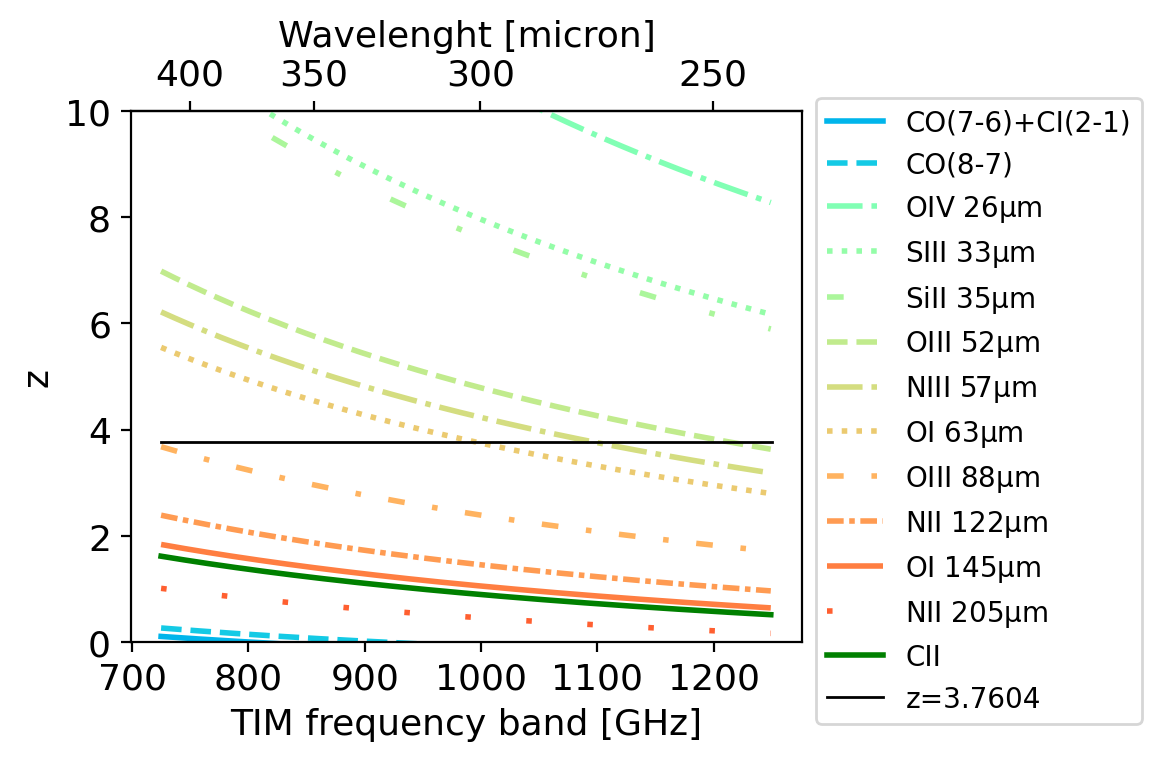

In [3]:
BS = 13; w = 2
plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS)
fig, ax = plt.subplots(figsize = (6,4), dpi=200)
ls=0
freqs = np.arange(725, 1250, 4)
colors = cm.rainbow(np.linspace(0,1,len(line_list)))

for line, nu_rest, c in zip(line_list, rest_freq_list, colors):
     if('CII' in line):c='g'
     if('CI(2-1)' in line): continue
     if('7-6' in line): line += '+CI(2-1)'
     if( ((nu_rest/freqs).value-1 >0).any() ):
          if( ((nu_rest/freqs).value-1 <= 10).any() ):
               ax.plot( freqs,  (nu_rest/freqs).value-1, label=line, c=c, linewidth=w, ls=line_styles[ls])
               print(line, line_styles[ls])
               ls+=1
ax.set_ylabel("z")
ax.set_xlabel("TIM frequency band [GHz]")
ax.set_ylim(0,10)
z=3.7604
ax.plot( (725, 1250),(z, z), c='k',  label=f'z={z}', lw=1)
#ax.fill_between(freqs, np.ones(freqs.shape)*2.9, np.ones(freqs.shape)*6, color='r', alpha=0.1)
#ax.fill_between(freqs, np.ones(freqs.shape)*0.6, np.ones(freqs.shape)*2.9, color='b', alpha=0.1)

ax.legend(bbox_to_anchor=(1.0, 1.05), fontsize=10 )
def w_to_f(x): return cst.c/(x*1e9)/1e-6
secax = ax.secondary_xaxis("top", functions=(w_to_f,w_to_f))
secax.set_xlabel('Wavelenght [micron]')
fig.tight_layout()
fig.savefig("interlopers.png", transparent=True)
plt.show()

/tmp/ipykernel_13454/3742099072.py:19: RuntimeWarning: divide by zero encountered in divide
  def w_to_f(x): return cst.c/(x*1e9)/1e-6


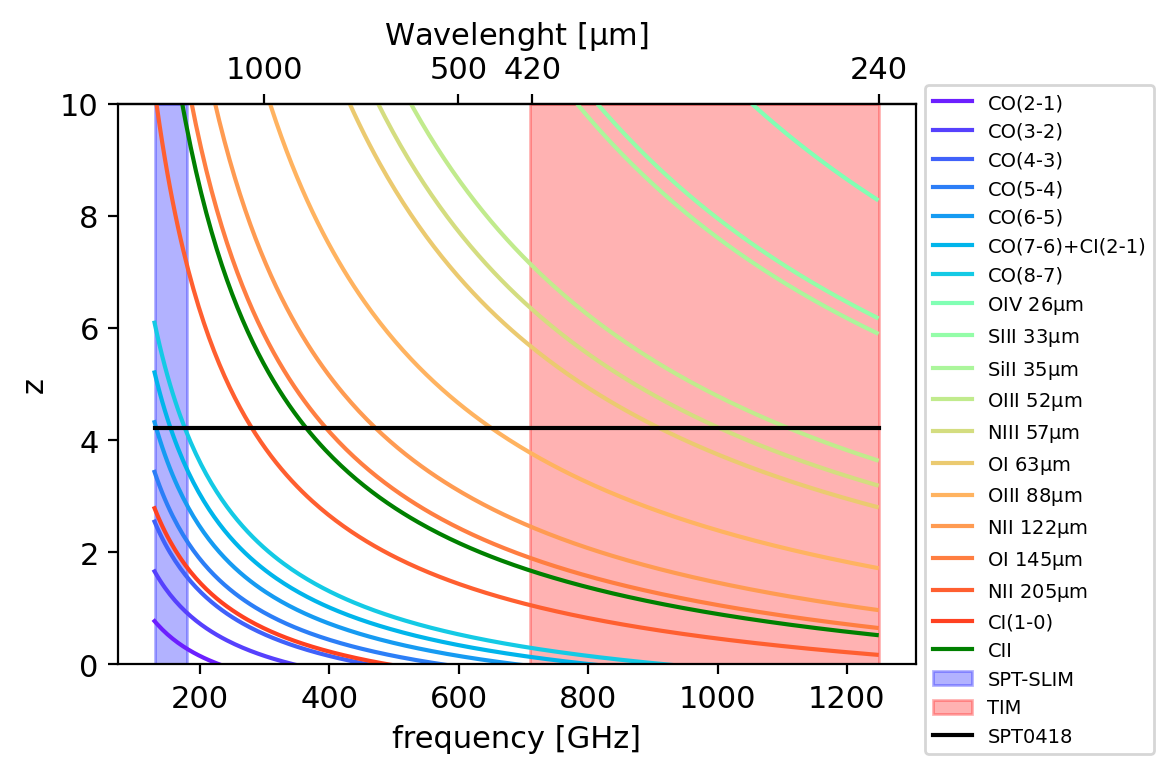

In [4]:
import matplotlib.ticker as ticker
BS = 11; w = 1.5
plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS)
fig, ax = plt.subplots(figsize = (6,4), dpi=200)
freqs = np.arange(130, 1250, 4)
for line, nu_rest, c in zip(line_list, rest_freq_list, colors):
     if('CII' in line):c='g'
     if('CI(2-1)' in line): continue
     if('7-6' in line): line += '+CI(2-1)'
     if( ((nu_rest/freqs).value-1 >0).any() ):
          if( ((nu_rest/freqs).value-1 <= 10).any() ):
               ax.plot( freqs,  (nu_rest/freqs).value-1, label=line, c=c, linewidth=w)
ax.fill_between((130, 180, 180, 130, 130), (0,0, 10, 10,0),color='b', label='SPT-SLIM', alpha=0.3)
ax.fill_between((710, 1250, 1250, 710, 710), (0,0, 10, 10,0), color='red', label='TIM', alpha=0.3)
ax.plot( (130, 1250),(4.2248, 4.2248), c='k', linewidth=w, label='SPT0418')
ax.set_ylabel("z"); ax.set_ylim(0,10)
ax.set_xlabel("frequency [GHz]")
ax.legend(bbox_to_anchor=(1.0, 1.05), fontsize=7 )
def w_to_f(x): return cst.c/(x*1e9)/1e-6
secax = ax.secondary_xaxis("top", functions=(w_to_f,w_to_f))
secax.set_xlabel('Wavelenght [$\\rm \\mu$m]')
secax.set_xticks([240, 420, 500, 1000])
secax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
fig.tight_layout()
fig.savefig("interlopers.png", transparent=True)
plt.show()

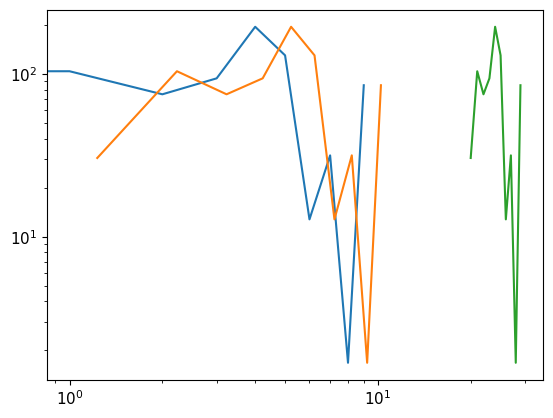

In [5]:
#Test spectutils
wavelengths = np.arange(0, 10) * u.um
flux = 100 * np.abs(np.random.default_rng(42).standard_normal(10)) * u.Jy
spectrum = Spectrum1D(spectral_axis=wavelengths, flux=flux)
plt.loglog(wavelengths, flux)
shift = 12300 * u.AA
new_spec = Spectrum1D(spectral_axis=spectrum.spectral_axis + shift, flux=spectrum.flux)
plt.plot(new_spec.spectral_axis, new_spec.flux)
shift = 200000 * u.AA
new_spec = Spectrum1D(spectral_axis=spectrum.spectral_axis + shift, flux=spectrum.flux)
plt.plot(new_spec.spectral_axis, new_spec.flux)

In [6]:
#TIM params
beam_FWHM_HF = 48*u.arcsec
Omega_beam_HF = (2*np.pi*(beam_FWHM_HF * gaussian_fwhm_to_sigma)**2).to(u.sr)
pixel_size_HF = Omega_beam_HF #((beam_FWHM_HF/2)**2).to(u.sr) #Nyquist: need to sample with 2 pixels the FWHM 
lambda_HF = noise_model_HF["# Wavelength[um]"]*1e3 #nm
nu_HF = cst.c/(lambda_HF*1e-9)/1e9 #GHz
dnu_HF = np.asarray(nu_HF[:-1]) - np.asarray(nu_HF[1:])
f = interp1d(nu_HF[1:], dnu_HF, bounds_error=False, kind='linear', fill_value='extrapolate')
dnu_HF =  f(nu_HF)
dv_HF = dnu_HF / nu_HF * cst.c*1e-3 #km/sec

beam_FWHM_LF = 37*u.arcsec
Omega_beam_LF = (2*np.pi*(beam_FWHM_LF * gaussian_fwhm_to_sigma)**2).to(u.sr)
pixel_size_LF = Omega_beam_LF #((beam_FWHM_LF/2)**2).to(u.sr) #Nyquist: need to sample with 2 pixels the FWHM
lambda_LF = noise_model_LF["# Wavelength[um]"]*1e3 #nm
nu_LF = cst.c/(lambda_LF*1e-9)/1e9 #GHz
dnu_LF = np.asarray(nu_LF[:-1]) - np.asarray(nu_LF[1:])
f = interp1d(nu_LF[1:], dnu_LF, bounds_error=False, kind='linear', fill_value='extrapolate')
dnu_LF = f(nu_LF)
dv_LF = dnu_LF / nu_LF * cst.c*1e-3 #km/sec

/tmp/ipykernel_13454/3512883010.py:14: RuntimeWarning: divide by zero encountered in divide
  def w_to_f(x): return cst.c/(x*1e-6)/1e9


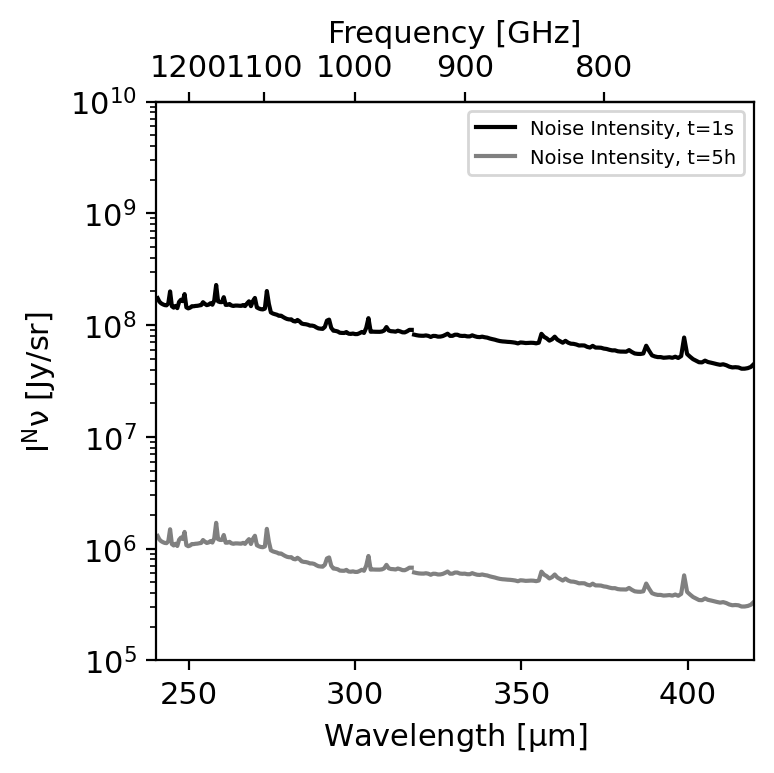

In [7]:
#compute the noise intensity out of the NEI and the survey time
t_survey = 5*3600
fig, ax = plt.subplots(figsize=(4,4), dpi=200)  
#ax.plot(w_source, source, 'orange', label=f'SPT0418@z={z}')
ax.plot(noise_model_HF["# Wavelength[um]"],   noise_model_HF["NEI[Jy/sr s^1/2]"], label='Noise Intensity, t=1s', c='k' )
ax.plot(noise_model_LF["# Wavelength[um]"],   noise_model_LF["NEI[Jy/sr s^1/2]"], c='k')
ax.loglog(noise_model_HF["# Wavelength[um]"], noise_model_HF["NEI[Jy/sr s^1/2]"]/np.sqrt(t_survey),  label='Noise Intensity, t=5h', c='grey')
ax.loglog(noise_model_LF["# Wavelength[um]"], noise_model_LF["NEI[Jy/sr s^1/2]"]/np.sqrt(t_survey),c='grey'  )
ax.set_xlabel("Wavelength [$\\rm \\mu$m]")
ax.set_ylabel("I$\\rm ^N \\nu$ [Jy/sr]")
ax.set_xscale("linear")
ax.set_ylim(1e5, 1e10)
ax.set_xlim(240,420)
def w_to_f(x): return cst.c/(x*1e-6)/1e9
secax = ax.secondary_xaxis("top", functions=(w_to_f,w_to_f))
secax.set_xlabel('Frequency [GHz]')
ax.legend(fontsize=7, loc='upper right')
fig.tight_layout()

In [8]:
df_radec = pd.read_csv("../reuter_2020_data/spt_dndz_tab_a1.txt", delimiter="\t", skiprows=3)
df_fluxes = pd.read_csv("../reuter_2020_data/spt_dndz_tab_d1.txt", delimiter="\t", skiprows=3)
df_propa = pd.read_csv("../reuter_2020_data/spt_dndz_tab_f1.txt", delimiter="\t", skiprows=3)
df_propb = pd.read_csv("../reuter_2020_data/spt_dndz_tab_f1_kappa_wd03.txt", delimiter="\t", skiprows=3)

from astropy.table import Table
data = Table.read('analysis_fcts/smg_dndz_tables.fits', hdu=1)
colors = cm.plasma(np.linspace(0,1,len(data)))

In [9]:
names = [name for name in data.colnames if len(data[name].shape) <= 1]
cat = data[names].to_pandas()
TIM = {'pixel_size':45*u.arcsec, 'freq_min':715e9*u.Hz, 'freq_max':1250e9*u.Hz, 'freq_resol':1e9*u.Hz}
cat['issb'] = False
cat['redshift'] = cat['z_spec']
cat['qflag'] = True
cat['SFR'] = cat['int_SFR']*1e3
cat, channels, lamda_um_channels, continuum, lines_intim, lines_index = gen_spt_sed(cat, TIM)

Generate SED properties and fluxes...
Compute luminosity distances since they have not been computed before...
Draw <U> parameters...
Load SED and LIR grids...
Generate LIR...
Generate monochromatic fluxes...
Generate LFIR...
SED properties of  81  generated in  0.04783487319946289 s
Compute the CO(1-0) fluxes...
Work on the ICO21 lines
Work on the ICO32 lines
Work on the ICO43 lines
Work on the ICO54 lines
Work on the ICO65 lines
Work on the ICO76 lines
Work on the ICO87 lines
CO line fluxes of  81  galaxies generated in  0.009418249130249023 s
Compute the [CII] fluxes using the Lagache relation....
Compute the [CII] fluxes using the de Looze relation....
[CII] line fluxes of  81  galaxies generated in  0.002370595932006836 s
[CI] line fluxes of  81  galaxies generated in  0.0043566226959228516 s
Far-IR line fluxes of  81  galaxies generated in  0.012873172760009766 s
generating the coordinates of the sources
Generate monochromatic fluxes...
Generate SIII33 fluxes...
9.790012769687907

/home/mvancuyck/anaconda3/envs/camb/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


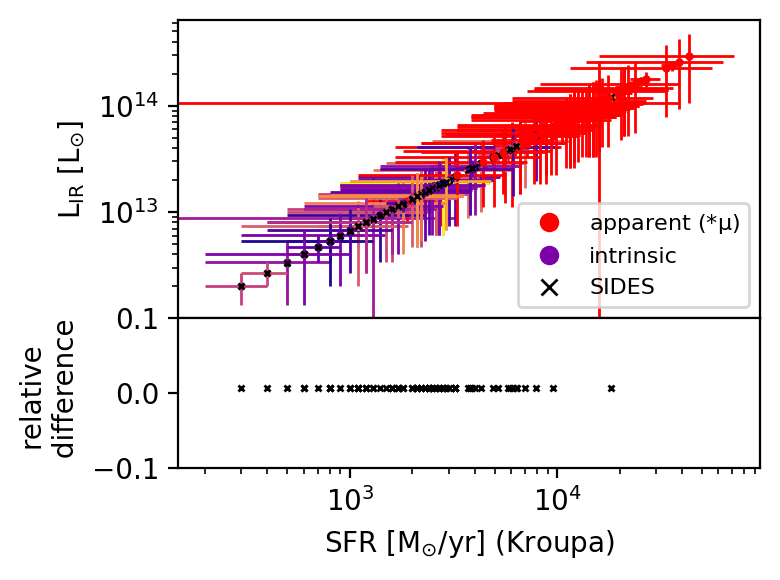

In [10]:
BS = 10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); mk = 3; lw=1

fig, (ax, axr) = plt.subplots(2, 1, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [2,1]}, figsize=(4, 3), dpi = 200)
for ismg, (smg,c) in enumerate(zip(data,colors)):

    zc = (smg['z_spec']-data['z_spec'].min())/(data['z_spec'].max()-data['z_spec'].min())
    c = cm.plasma(zc)
        
    ax.errorbar( smg['app_SFR']*1e3, smg['app_lir']*1e3,  yerr=smg['app_lir_err']*1e3, xerr=smg['app_SFR_err']*1e3 ,
                fmt='o', color='r', ecolor='r', label=smg, markersize=2, linewidth=1 )
    
    ax.errorbar( smg['int_SFR']*1e3, smg['int_lir']*1e3, yerr=smg['int_lir_err']*1e3, xerr=smg['int_SFR_err']*1e3,
                fmt='o', color=c, ecolor=c, label=smg, markersize=2, linewidth=1 )
    
    ax.errorbar(cat['SFR'][ismg], cat['LIR'][ismg],
                fmt='x', color='k', ecolor=c, label=smg, markersize=2, linewidth=1 )
    
    axr.errorbar(cat['SFR'][ismg], smg['int_lir']*1e3/cat['LIR'][ismg]-1,
                fmt='x', color='k', ecolor=c, label=smg, markersize=2, linewidth=1 )
    
patchs = []
patch = mlines.Line2D([], [], color='r', marker='o' , linestyle='None',  label='apparent (*$\\rm \\mu$)'); patchs.append(patch)
patch = mlines.Line2D([], [], color=c,   marker='o',  linestyle="None",  label='intrinsic'); patchs.append(patch)
patch = mlines.Line2D([], [], color='k',   marker='x',  linestyle="None",  label='SIDES'); patchs.append(patch)
ax.legend(handles = patchs, loc = 'lower right', fontsize=8)
axr.set_ylim(-0.1, 0.1)
axr.set_xlabel('SFR [$\\rm M_{\\odot}/yr$] (Kroupa)')
ax.set_ylabel('$\\rm L_{IR}$ [$\\rm L_{\\odot}$]')
ax.set_yscale('log'); ax.set_xscale('log')
axr.set_ylabel('relative \n difference')
fig.tight_layout()
fig.subplots_adjust(hspace=0, wspace=0)
#ax.legend(bbox_to_anchor=(1.0, 1.05), fontsize=8 )


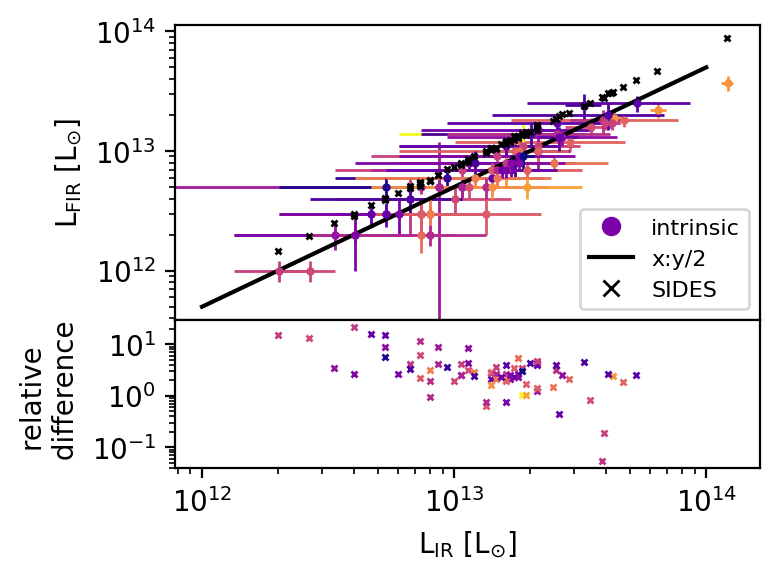

In [11]:
BS = 10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); mk = 3; lw=1
fig, (ax, axr) = plt.subplots(2, 1, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [2,1]}, figsize=(4, 3), dpi = 200)
for ismg, (smg,c) in enumerate(zip(data,colors)):

    zc = (smg['z_spec']-data['z_spec'].min())/(data['z_spec'].max()-data['z_spec'].min())
    c = cm.plasma(zc)
    
    ax.errorbar(smg['int_lir']*1e3,smg['int_lfir']*1e13, yerr=smg['int_lfir_err']*1e13, xerr=smg['int_lir_err']*1e3,
                fmt='o', color=c, ecolor=c, label=smg, markersize=2, linewidth=1 )
    #ax.errorbar(smg['app_lir']*1e3,smg['app_lfir']*1e13, yerr=smg['app_lfir_err']*1e13, xerr=smg['app_lir_err']*1e3,
                #fmt='>', color='r', ecolor='r', label=smg, markersize=2, linewidth=1 )
    ax.errorbar(cat['LIR'][ismg], cat['LFIR'][ismg], 
                fmt='x', color='k', ecolor=c, label=smg, markersize=2, linewidth=1 )
    axr.errorbar(cat['LIR'][ismg], (smg['app_lfir']*1e13)/cat['LFIR'][ismg]-1, 
                fmt='x', color=c, ecolor=c, label=smg, markersize=2, linewidth=1 )
ax.loglog((1e12, 1e14),np.asarray((1e12, 1e14))/2, 'k' )
ax.set_ylabel('$\\rm L_{FIR}$ [$\\rm L_{\\odot}$]');
axr.set_ylabel('relative \n difference'); 
axr.set_xlabel('$\\rm L_{IR}$ [$\\rm L_{\\odot}$]')
ax.set_yscale('log'); ax.set_xscale('log')
axr.set_yscale('log')
patchs = []
#patch = mlines.Line2D([], [], color='r', marker='o' , linestyle='None',  label='apparent'); patchs.append(patch)
patch = mlines.Line2D([], [], color=c,   marker='o',  linestyle="None",  label='intrinsic'); patchs.append(patch)
patch = mlines.Line2D([], [], color='k',  linestyle="solid",  label='x:y/2'); patchs.append(patch)
patch = mlines.Line2D([], [], color='k',   marker='x',  linestyle="None",  label='SIDES'); patchs.append(patch)
ax.legend(handles = patchs, loc = 'lower right', fontsize=8)
#ax.legend(bbox_to_anchor=(1.0, 1.05), fontsize=8 )
fig.tight_layout()
fig.subplots_adjust(hspace=0, wspace=0)


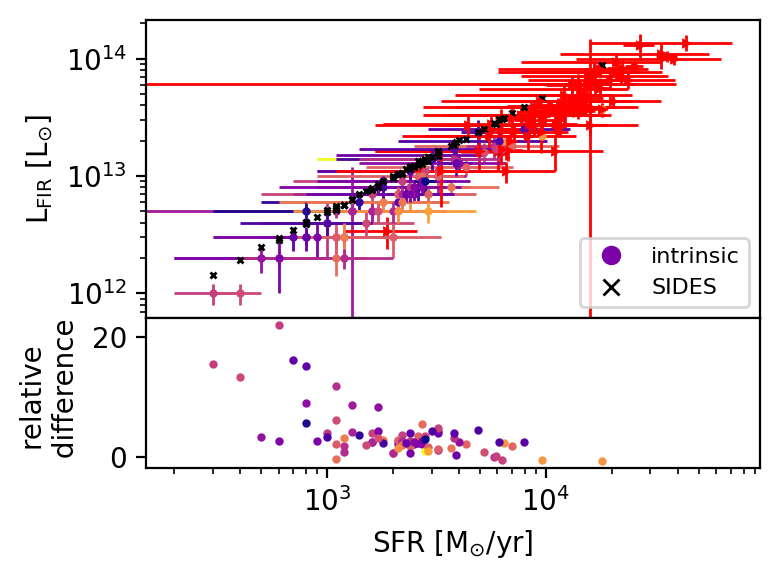

In [13]:
BS = 10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); mk = 3; lw=1
fig, (ax, axr) = plt.subplots(2, 1, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [2,1]}, figsize=(4, 3), dpi = 200)
for ismg, (smg,c) in enumerate(zip(data,colors)):

    zc = (smg['z_spec']-data['z_spec'].min())/(data['z_spec'].max()-data['z_spec'].min())
    c = cm.plasma(zc)

    ax.errorbar(smg['int_SFR']*1e3,smg['int_lfir']*1e13, yerr=smg['int_lfir_err']*1e13, xerr=smg['int_SFR_err']*1e3,
                fmt='o', color=c, ecolor=c, label=smg, markersize=2, linewidth=1 )
    ax.errorbar(smg['app_SFR']*1e3,smg['app_lfir']*1e13, yerr=smg['app_lfir_err']*1e13, xerr=smg['app_SFR_err']*1e3,
                fmt='>', color='r', ecolor='r', label=smg, markersize=2, linewidth=1 )
    ax.errorbar(cat['SFR'][ismg], cat['LFIR'][ismg], 
                fmt='x', color='k', ecolor=c, label=smg, markersize=2, linewidth=1 )
    axr.errorbar(smg['int_SFR']*1e3, (smg['app_lfir']*1e13)/cat['LFIR'][ismg]-1, 
                fmt='o', color=c, ecolor=c, label=smg, markersize=2, linewidth=1 )
    
ax.set_ylabel('$\\rm L_{FIR}$ [$\\rm L_{\\odot}$]');
axr.set_ylabel('relative \n difference')
axr.set_xlabel('SFR [$\\rm M_{\\odot}/yr$]')
ax.set_yscale('log'); ax.set_xscale('log')
patchs = []
#patch = mlines.Line2D([], [], color='r', marker='o' , linestyle='None',  label='apparent'); patchs.append(patch)
patch = mlines.Line2D([], [], color=c,   marker='o',  linestyle="None",  label='intrinsic'); patchs.append(patch)
patch = mlines.Line2D([], [], color='k',   marker='x',  linestyle="None",  label='SIDES'); patchs.append(patch)
ax.legend(handles = patchs, loc = 'lower right', fontsize=8)
#ax.legend(bbox_to_anchor=(1.0, 1.05), fontsize=8 )
fig.tight_layout()
fig.subplots_adjust(hspace=0, wspace=0)

In [14]:
SED = fits.getdata("analysis_fcts/SPT0418-47_best_model_main.fits")
#The redshift from the fits file
z0 = 4.2248
#The redshift I want
z = z0; 
#load SED from the file
Spectrum = Spectrum1D(spectral_axis=SED['wavelength']*u.nm, flux=SED['Fnu']*u.mJy)
shift = ((1+z)/(1+z0)-1 )*SED['wavelength']*u.nm
#shift it to my redshift
new_spec = Spectrum1D(spectral_axis=Spectrum.spectral_axis + shift, flux=Spectrum.flux)
lambda_SED_micron = new_spec.spectral_axis*1e-3; 
SED_inJy = 1e-3*new_spec.flux*((1+z0)/(1+z))**4 

'\nfor ismg, (smg, c) in enumerate(zip(data,colors)):\n\n    BS = 10; plt.rc(\'font\', size=BS); plt.rc(\'axes\', titlesize=BS); plt.rc(\'axes\', labelsize=BS); mk = 3; lw=1\n    fig, (ax, axr) = plt.subplots(2, 1, sharex=True, sharey = \'row\', gridspec_kw={\'height_ratios\': [2,1]}, figsize=(6, 6), dpi = 200)\n    patchs = []\n\n    colors = cm.Greys(np.linspace(0,1,len(data)))\n    l = np.hstack((noise_model_HF["# Wavelength[um]"], noise_model_LF["# Wavelength[um]"]))\n\n    zc = (smg[\'z_spec\']-data[\'z_spec\'].min())/(data[\'z_spec\'].max()-data[\'z_spec\'].min())\n    c2 = cm.coolwarm(zc)\n    if(zc==0):   patch = mlines.Line2D([], [], color=c2, linestyle="solid",label=f"z={smg[\'z_spec\']}, SIDES" ); patchs.append(patch)\n    if(zc==1.0): patch = mlines.Line2D([], [], color=c2, linestyle="solid", label=f"z={smg[\'z_spec\']}, SIDES"); patchs.append(patch)\n    \n    spec = Spectrum1D(spectral_axis=(smg[\'um_obs_pl\']*(1+smg[\'z_spec\']))[:,0]*u.um, flux=smg[\'fit_pl\'][:,0]*u.mJ

/tmp/ipykernel_13454/1460187402.py:39: RuntimeWarning: divide by zero encountered in divide
  def w_to_f(x): return cst.c/(x*1e-6)/1e9


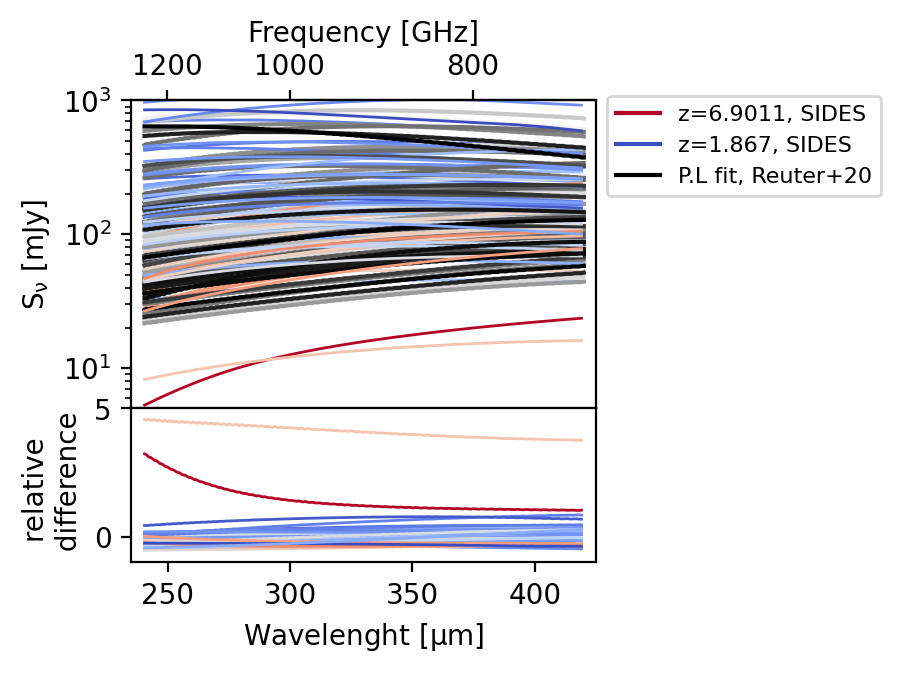

In [15]:
resample_grid = (np.hstack((noise_model_HF["# Wavelength[um]"], noise_model_LF["# Wavelength[um]"]))*u.micron)

BS = 10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); mk = 3; lw=1
fig, (ax, axr) = plt.subplots(2, 1, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [2,1]}, figsize=(3, 3), dpi = 200)
patchs = []

colors = cm.Greys(np.linspace(0,1,len(data)))
for ismg, (smg, c) in enumerate(zip(data,colors)):
    l = np.hstack((noise_model_HF["# Wavelength[um]"], noise_model_LF["# Wavelength[um]"]))

    zc = (smg['z_spec']-data['z_spec'].min())/(data['z_spec'].max()-data['z_spec'].min())
    c2 = cm.coolwarm(zc)
    if(zc==0):   patch = mlines.Line2D([], [], color=c2, linestyle="solid",label=f"z={smg['z_spec']}, SIDES" ); patchs.append(patch)
    if(zc==1.0): patch = mlines.Line2D([], [], color=c2, linestyle="solid", label=f"z={smg['z_spec']}, SIDES"); patchs.append(patch)
    
    spec = Spectrum1D(spectral_axis=(smg['um_obs_pl']*(1+smg['z_spec']))[:,0]*u.um, flux=smg['fit_pl'][:,0]*u.mJy)
    lambda_SED = spec.spectral_axis; SED = spec.flux
    input_spectra  = Spectrum1D( flux=SED, spectral_axis=lambda_SED)
    fluxc_resample = FluxConservingResampler()
    sed_in_tim = fluxc_resample(input_spectra, resample_grid) #resample_grid)  
    ax.loglog(resample_grid, sed_in_tim.flux, c=c)
    
    spec = Spectrum1D(spectral_axis=lamda_um_channels[::-1], flux=continuum[ismg][::-1].to(u.mJy))
    lambda_SED = spec.spectral_axis; SED = spec.flux
    input_spectra  = Spectrum1D( flux=SED, spectral_axis=lambda_SED)
    fluxc_resample = FluxConservingResampler()
    cont_in_tim = fluxc_resample(input_spectra, resample_grid) #resample_grid)    
    ax.loglog(l, cont_in_tim.flux, c=c2, lw=1)
    axr.plot( l, (sed_in_tim.flux/cont_in_tim.flux)-1, c=c2, lw=1)

#ax.loglog(SED['wavelength']*1e-3, SED['Fnu'], color='lime', lw=1)
#patch = mlines.Line2D([], [], color='lime',  linestyle="solid", label = f'SPT0418@z={z}'); patchs.append(patch)
ax.set_ylabel('$\\rm S_{\\nu}$ [mJy]'); axr.set_xlabel('Wavelenght [$\\rm \\mu$m]')
ax.set_yscale('log'); ax.set_xscale('linear')
ax.set_xlim(235,425)
ax.set_ylim(5e0, 1e3)
axr.set_ylim(-1, 5)
axr.set_ylabel('relative \n difference')
def w_to_f(x): return cst.c/(x*1e-6)/1e9
secax = ax.secondary_xaxis("top", functions=(w_to_f,w_to_f))
secax.set_xlabel('Frequency [GHz]')
patch = mlines.Line2D([], [], color='k',  linestyle="solid", label='P.L fit, Reuter+20'); patchs.append(patch)
#patch = mlines.Line2D([], [],   marker='o',  color="g",linestyle="None",  label='Phot. points, Reuter+20'); patchs.append(patch)
#patch = mlines.Line2D([], [],   color="purple",linestyle="--",  label='Phot. points, SIDES'); patchs.append(patch)
ax.legend(handles = patchs, loc = 'upper left', fontsize=8, bbox_to_anchor=(1.0, 1.05))
#fig.tight_layout()
fig.subplots_adjust(hspace=0, wspace=0)
#20, 
### INDIVIDUAL
'''
for ismg, (smg, c) in enumerate(zip(data,colors)):

    BS = 10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); mk = 3; lw=1
    fig, (ax, axr) = plt.subplots(2, 1, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [2,1]}, figsize=(6, 6), dpi = 200)
    patchs = []

    colors = cm.Greys(np.linspace(0,1,len(data)))
    l = np.hstack((noise_model_HF["# Wavelength[um]"], noise_model_LF["# Wavelength[um]"]))

    zc = (smg['z_spec']-data['z_spec'].min())/(data['z_spec'].max()-data['z_spec'].min())
    c2 = cm.coolwarm(zc)
    if(zc==0):   patch = mlines.Line2D([], [], color=c2, linestyle="solid",label=f"z={smg['z_spec']}, SIDES" ); patchs.append(patch)
    if(zc==1.0): patch = mlines.Line2D([], [], color=c2, linestyle="solid", label=f"z={smg['z_spec']}, SIDES"); patchs.append(patch)
    
    spec = Spectrum1D(spectral_axis=(smg['um_obs_pl']*(1+smg['z_spec']))[:,0]*u.um, flux=smg['fit_pl'][:,0]*u.mJy)
    lambda_SED = spec.spectral_axis; SED = spec.flux
    input_spectra  = Spectrum1D( flux=SED, spectral_axis=lambda_SED)
    fluxc_resample = FluxConservingResampler()
    sed_in_tim = fluxc_resample(input_spectra, resample_grid) #resample_grid)  
    ax.loglog(resample_grid, sed_in_tim.flux, c=c)
    
    spec = Spectrum1D(spectral_axis=lamda_um_channels[::-1], flux=continuum[ismg][::-1].to(u.mJy))
    lambda_SED = spec.spectral_axis; SED = spec.flux
    input_spectra  = Spectrum1D( flux=SED, spectral_axis=lambda_SED)
    fluxc_resample = FluxConservingResampler()
    cont_in_tim = fluxc_resample(input_spectra, resample_grid) #resample_grid)    
    ax.loglog(l, cont_in_tim.flux, c=c2, lw=1)
    axr.plot( l, (sed_in_tim.flux/cont_in_tim.flux)-1, c=c2, lw=1)

    #ax.loglog(SED['wavelength']*1e-3, SED['Fnu'], color='lime', lw=1)
    patch = mlines.Line2D([], [], color='lime',  linestyle="solid", label = f'SPT0418@z={z}'); patchs.append(patch)
    ax.set_ylabel('$\\rm S_{\\nu}$ [mJy]'); axr.set_xlabel('Wavelenght [$\\rm \\mu$m]')
    ax.set_yscale('log'); ax.set_xscale('linear')
    ax.set_xlim(235,425)
    ax.set_ylim(5e0, 1e3)
    axr.set_ylim(-1, 5)
    axr.set_ylabel('relative \n difference')
    def w_to_f(x): return cst.c/(x*1e-6)/1e9
    secax = ax.secondary_xaxis("top", functions=(w_to_f,w_to_f))
    secax.set_xlabel('Frequency [GHz]')
    patch = mlines.Line2D([], [], color='k',  linestyle="solid", label='P.L fit, Reuter+20'); patchs.append(patch)
    #patch = mlines.Line2D([], [],   marker='o',  color="g",linestyle="None",  label='Phot. points, Reuter+20'); patchs.append(patch)
    #patch = mlines.Line2D([], [],   color="purple",linestyle="--",  label='Phot. points, SIDES'); patchs.append(patch)
    ax.legend(handles = patchs, loc = 'upper left', fontsize=8, bbox_to_anchor=(1.0, 1.05))
    #fig.tight_layout()
    fig.subplots_adjust(hspace=0, wspace=0)
    plt.savefig(f"{ismg}_{smg['spt_id']}.png", transparent=True)
    #20,  32
    plt.close()
'''

/home/mvancuyck/anaconda3/envs/camb/lib/python3.9/site-packages/matplotlib/cbook.py:1345: UserWarning: Warning: converting a masked element to nan.
  return np.asarray(x, float)
/home/mvancuyck/anaconda3/envs/camb/lib/python3.9/site-packages/numpy/ma/core.py:3387: UserWarning: Warning: converting a masked element to nan.
  _data[indx] = dval
/home/mvancuyck/anaconda3/envs/camb/lib/python3.9/site-packages/matplotlib/cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


/tmp/ipykernel_15970/4062021450.py:29: RuntimeWarning: divide by zero encountered in divide
  def w_to_f(x): return cst.c/(x*1e-6)/1e9


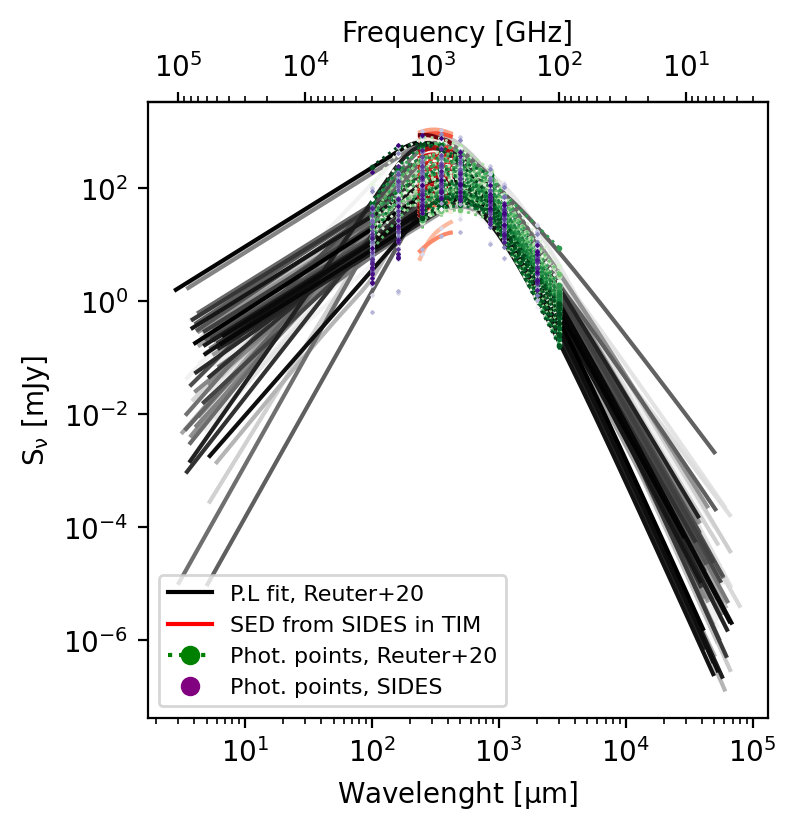

In [15]:
BS = 10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); mk = 3; lw=1
fig, ax = plt.subplots(figsize=(4.0,4.0), dpi=200) 

colors = cm.Greens(np.linspace(0,1,len(data)))
for ismg, (smg,c) in enumerate(zip(data,colors)):
    ax.errorbar( np.asarray((3,             0.870,          0.5,           0.35,           0.25,           0.16,           0.1))*1e3, 
                (smg['S_3mm'],  smg['S_870'],   smg['S_500'],  smg['S_350'],   smg['S_250'],   smg['S_160'],   smg['S_100']), 
                yerr= (smg['err_3mm'],smg['err_870'], smg['err_500'],smg['err_350'], smg['err_250'], smg['err_160'], smg['err_100']),
                fmt=':o', color=c, ecolor=c, label=smg, markersize=1, linewidth=1, )


colors = cm.Greys(np.linspace(0,1,len(data)))
for ismg, (smg,c) in enumerate(zip(data,colors)):
    ax.loglog(smg['um_obs_pl']*(1+smg['z_spec']), smg['fit_pl'], c=c)


colors = cm.Purples(np.linspace(0,1,len(data)))
for ismg, (smg,c) in enumerate(zip(data,colors)):
    ax.errorbar(np.asarray((2,1.1,0.850, 0.5, 0.35, 0.25, 0.16, 0.1))*1e3, np.asarray((cat['S2000'][ismg],cat['S1100'][ismg],cat['S850'][ismg], 
                                                           cat['S500'][ismg],cat['S350'][ismg], cat['S250'][ismg], cat['S160'][ismg], 
                                                           cat['S100'][ismg]))*1e3, 
                                                           fmt='x', color=c, ecolor=c, label=smg, markersize=1, linewidth=1, )
colors = cm.Reds(np.linspace(0,1,len(data)))
for ismg, (smg,c) in enumerate(zip(data,colors)):
    ax.loglog(lamda_um_channels, continuum[ismg]*1e3, c=c)

ax.set_ylabel('$\\rm S_{\\nu}$ [mJy]'); ax.set_xlabel('Wavelenght [$\\rm \\mu$m]')
ax.set_yscale('log'); ax.set_xscale('log')
def w_to_f(x): return cst.c/(x*1e-6)/1e9
secax = ax.secondary_xaxis("top", functions=(w_to_f,w_to_f))
secax.set_xlabel('Frequency [GHz]')
patchs = []
patch = mlines.Line2D([], [], color='k',  linestyle="solid", label='P.L fit, Reuter+20'); patchs.append(patch)
patch = mlines.Line2D([], [],   color="r",linestyle="solid",  label='SED from SIDES in TIM'); patchs.append(patch)
patch = mlines.Line2D([], [],   marker='o',  color="g",linestyle=":",  label='Phot. points, Reuter+20'); patchs.append(patch)
patch = mlines.Line2D([], [],   marker='o',color="purple",linestyle="None",  label='Phot. points, SIDES'); patchs.append(patch)
ax.legend(handles = patchs, loc = 'lower left', fontsize=8,)# bbox_to_anchor=(1.0, 1.05))

/tmp/ipykernel_13454/1525407545.py:42: RuntimeWarning: divide by zero encountered in divide
  def w_to_f(x): return cst.c/(x*1e-6)/1e9


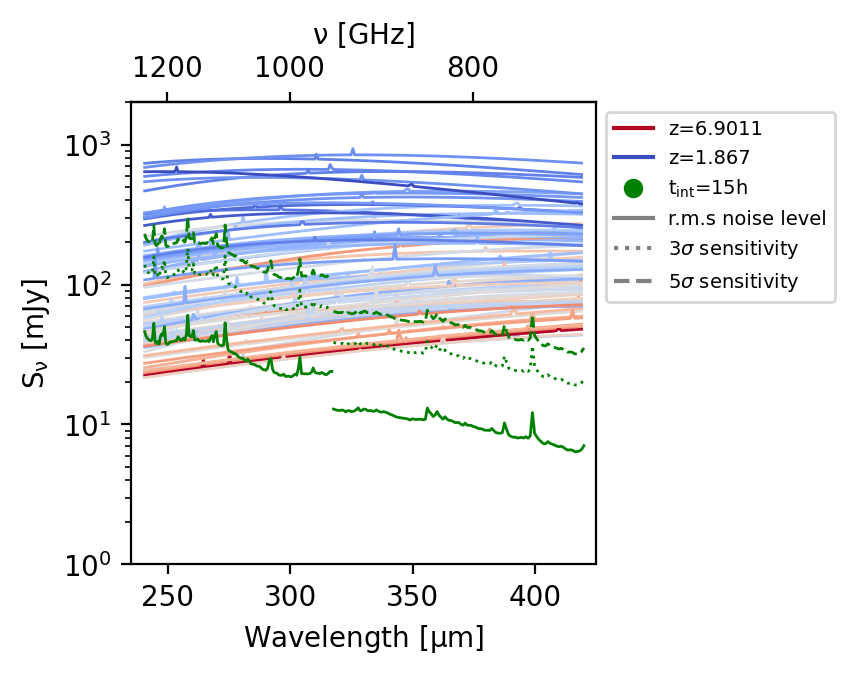

In [25]:
NEFD_HF = noise_model_HF["NEI[Jy/sr s^1/2]"]*Omega_beam_HF*1e3
NEFD_LF = noise_model_LF["NEI[Jy/sr s^1/2]"]*Omega_beam_LF*1e3
patchs = []

BS = 10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); mk = 3; lw=1
fig, ax = plt.subplots(figsize=(3.0,3.0), dpi=200) 

for ismg, (smg,c) in enumerate(zip(data,colors)):
    zc = (smg['z_spec']-data['z_spec'].min())/(data['z_spec'].max()-data['z_spec'].min())
    c = cm.coolwarm(zc)
    if(zc==0):   patch = mlines.Line2D([], [], color=c, linestyle="solid",label=f"z={smg['z_spec']}" ); patchs.append(patch)
    if(zc==1.0): patch = mlines.Line2D([], [], color=c, linestyle="solid", label=f"z={smg['z_spec']}"); patchs.append(patch)
    #ax.loglog(lamda_um_channels, continuum[ismg].value*1e3+lines_intim[ismg]*1e3, c=c,lw=1)
    
    f = interp1d((smg['um_obs_pl']*(1+smg['z_spec']))[:,0], smg['fit_pl'][:,0] )
    cont_res = f(lamda_um_channels[::-1] )
    spec = Spectrum1D(spectral_axis=lamda_um_channels[::-1], flux=cont_res*u.mJy+lines_intim[ismg][::-1]*1e3*u.mJy)
    lambda_SED = spec.spectral_axis; SED = spec.flux
    input_spectra  = Spectrum1D( flux=SED, spectral_axis=lambda_SED)
    fluxc_resample = FluxConservingResampler()
    sides_in_tim = fluxc_resample(input_spectra, resample_grid) #resample_grid)    
    ax.loglog(l, sides_in_tim.flux, c=c, lw=1)


for t, c in zip((15,), ('g', 'lime', 'magenta')):
    ax.loglog(noise_model_HF["# Wavelength[um]"], NEFD_HF/np.sqrt(t*3600), c=c,lw=1)
    ax.loglog(noise_model_LF["# Wavelength[um]"], NEFD_LF/np.sqrt(t*3600), c=c,lw=1  )
    patch = mlines.Line2D([], [],   marker='o',  color=c,linestyle="None",  label='$\\rm t_{int}$='+f'{int(t)}h'); patchs.append(patch)
    for n, ls in zip((3,5), (':', '--') ):
        ax.loglog(noise_model_HF["# Wavelength[um]"], n*NEFD_HF/np.sqrt(t*3600), ls=ls, c=c,lw=1) #label=f'{n}'+'$\\rm \\sigma$ sensitivity',
        ax.loglog(noise_model_LF["# Wavelength[um]"], n*NEFD_LF/np.sqrt(t*3600), ls=ls, c=c,lw=1)

patch = mlines.Line2D([], [], color='gray',  linestyle="solid",  label = 'r.m.s noise level',); patchs.append(patch)
patch = mlines.Line2D([], [], color='gray',  linestyle=":",  label = '3$\\sigma$ sensitivity',); patchs.append(patch)
patch = mlines.Line2D([], [], color='gray',  linestyle="--",  label = '5$\\sigma$ sensitivity',); patchs.append(patch)

ax.set_xlabel('Wavelength $\\rm [\\mu m]$')
ax.set_xlim(235, 425)
ax.set_ylabel('$\\rm S_{\\nu}$ [mJy]')
ax.set_ylim(1e0, 2e3)
ax.set_xscale('linear')
def w_to_f(x): return cst.c/(x*1e-6)/1e9
secax = ax.secondary_xaxis("top", functions=(w_to_f,w_to_f))
secax.set_xlabel('$\\rm \\nu$ [GHz]')
ax.legend(handles = patchs,fontsize=7, bbox_to_anchor=(1,1))

In [27]:

FIR_lines_list = [r'SIII 33$\rm \mu m$', r'SiII 35$\rm \mu m$', r'OIII 52$\rm \mu m$', 
                   r'NIII 57$\rm \mu m$', r'OI 63$\rm \mu m$', r'OIII 88$\rm \mu m$', r'NII 122$\rm \mu m$',
                   r'OI 145$\rm \mu m$'] 
FIR_lines_nu =   [8954.37449223,  8609.77765652,  5786.382127  , 5230.15453594,  4746.55569981,  3392.85262562,  2459.33107465, 2060.4292646]

tim_noise = np.hstack((NEFD_HF, NEFD_LF))
tim_w = np.hstack((noise_model_HF["# Wavelength[um]"], noise_model_LF["# Wavelength[um]"]))*u.um
# Calculate the differences between adjacent bin centers
diffs = (np.diff(tim_w) / 2.0).value
# Calculate the edges
bin_edges = np.zeros(len(tim_w) + 1)
bin_edges[1:-1] = tim_w[:-1].value + diffs
bin_edges[0] = tim_w[0].value - diffs[0]
bin_edges[-1] = tim_w[-1].value + diffs[-1]

/tmp/ipykernel_13454/4282313043.py:69: RuntimeWarning: divide by zero encountered in divide
  def w_to_f(x): return cst.c/(x*1e-6)/1e9


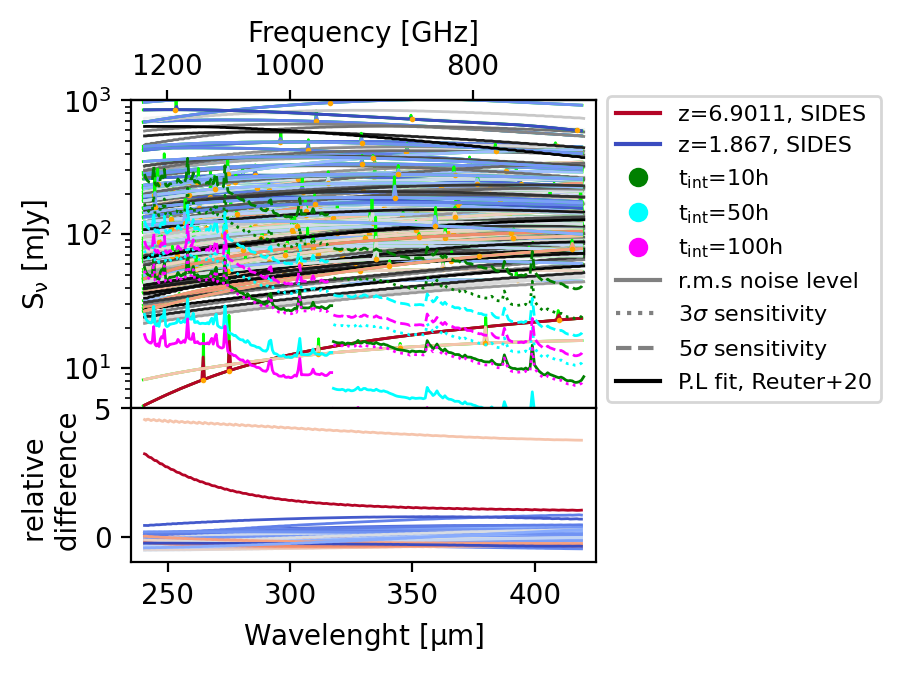

In [28]:
resample_grid = (np.hstack((noise_model_HF["# Wavelength[um]"], noise_model_LF["# Wavelength[um]"]))*u.micron)

BS = 10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); mk = 3; lw=1
fig, (ax, axr) = plt.subplots(2, 1, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [2,1]}, figsize=(3, 3), dpi = 200)
patchs = []

colors = cm.Greys(np.linspace(0,1,len(data)))
for ismg, (smg, c) in enumerate(zip(data,colors)):
    l = np.hstack((noise_model_HF["# Wavelength[um]"], noise_model_LF["# Wavelength[um]"]))

    spec = Spectrum1D(spectral_axis=(smg['um_obs_pl']*(1+smg['z_spec']))[:,0]*u.um, flux=smg['fit_pl'][:,0]*u.mJy)
    lambda_SED = spec.spectral_axis; SED = spec.flux
    input_spectra  = Spectrum1D( flux=SED, spectral_axis=lambda_SED)
    fluxc_resample = FluxConservingResampler()
    sed_in_tim = fluxc_resample(input_spectra, resample_grid) 
    #ax.loglog(smg['um_obs_pl']*(1+smg['z_spec']), smg['fit_pl'], c=c) # == sed in tim
    ax.loglog(resample_grid, sed_in_tim.flux, c=c, lw=1)

    zc = (smg['z_spec']-data['z_spec'].min())/(data['z_spec'].max()-data['z_spec'].min())
    c2 = cm.coolwarm(zc)
    if(zc==0):   patch = mlines.Line2D([], [], color=c2, linestyle="solid",label=f"z={smg['z_spec']}, SIDES" ); patchs.append(patch)
    if(zc==1.0): patch = mlines.Line2D([], [], color=c2, linestyle="solid", label=f"z={smg['z_spec']}, SIDES"); patchs.append(patch)
    ax.loglog(lamda_um_channels, continuum[ismg].value*1e3+lines_intim[ismg]*1e3, c='lime',lw=1)

    spec = Spectrum1D(spectral_axis=lamda_um_channels[::-1], flux=continuum[ismg][::-1].to(u.mJy))
    lambda_SED = spec.spectral_axis; SED = spec.flux
    input_spectra  = Spectrum1D( flux=SED, spectral_axis=lambda_SED)
    fluxc_resample = FluxConservingResampler()
    cont_in_tim = fluxc_resample(input_spectra, resample_grid) #resample_grid)    
    ax.loglog(l, cont_in_tim.flux, c=c2, lw=1)

    spec = Spectrum1D(spectral_axis=lamda_um_channels[::-1], flux=continuum[ismg][::-1].to(u.mJy)+lines_intim[ismg][::-1]*1e3*u.mJy)
    lambda_SED = spec.spectral_axis; SED = spec.flux
    input_spectra  = Spectrum1D( flux=SED, spectral_axis=lambda_SED)
    fluxc_resample = FluxConservingResampler()
    sides_in_tim = fluxc_resample(input_spectra, resample_grid) #resample_grid)    
    ax.loglog(l, sides_in_tim.flux, c=c2, lw=1)
    axr.plot( l, (sed_in_tim.flux/cont_in_tim.flux)-1, c=c2, lw=1)
        
    for j, (J, rest_freq) in enumerate(zip(FIR_lines_list, FIR_lines_nu)):
        w = cst.c / (rest_freq*1e9) *1e6
        w_obs = w * (1+smg['z_spec'])
        bin_index = np.digitize(w_obs, bin_edges) - 1  # Subtract 1 for zero-based index
        if(bin_index >= 0 and bin_index <= len(tim_w)-1):        
            closest_bin_center_index = np.argmin(np.abs(tim_w.value - w_obs))
            ax.loglog(tim_w[closest_bin_center_index], cont_in_tim.flux[closest_bin_center_index], 'o', c='orange', markersize = 1 )

for t, c in zip((10,50, 100), ('g', 'cyan', 'magenta')):
    ax.loglog(noise_model_HF["# Wavelength[um]"], NEFD_HF/np.sqrt(t*3600), c=c,lw=1)
    ax.loglog(noise_model_LF["# Wavelength[um]"], NEFD_LF/np.sqrt(t*3600), c=c,lw=1  )
    patch = mlines.Line2D([], [],   marker='o',  color=c,linestyle="None",  label='$\\rm t_{int}$='+f'{int(t)}h'); patchs.append(patch)
    for n, ls in zip((3,5), (':', '--') ):
        print("")
        #ax.loglog(noise_model_HF["# Wavelength[um]"], n*NEFD_HF/np.sqrt(t*3600), ls=ls, c=c,lw=1) #label=f'{n}'+'$\\rm \\sigma$ sensitivity',
        #ax.loglog(noise_model_LF["# Wavelength[um]"], n*NEFD_LF/np.sqrt(t*3600), ls=ls, c=c,lw=1)

patch = mlines.Line2D([], [], color='gray',  linestyle="solid",  label = 'r.m.s noise level',); patchs.append(patch)
patch = mlines.Line2D([], [], color='gray',  linestyle=":",  label = '3$\\sigma$ sensitivity',); patchs.append(patch)
patch = mlines.Line2D([], [], color='gray',  linestyle="--",  label = '5$\\sigma$ sensitivity',); patchs.append(patch)


#ax.loglog(SED['wavelength']*1e-3, SED['Fnu'], color='lime', lw=1)
#patch = mlines.Line2D([], [], color='lime',  linestyle="solid", label = f'SPT0418@z={z}'); patchs.append(patch)
ax.set_ylabel('$\\rm S_{\\nu}$ [mJy]'); axr.set_xlabel('Wavelenght [$\\rm \\mu$m]')
ax.set_yscale('log'); ax.set_xscale('linear')
ax.set_xlim(235,425)
ax.set_ylim(5e0, 1e3)
axr.set_ylim(-1, 5)
axr.set_ylabel('relative \n difference')
def w_to_f(x): return cst.c/(x*1e-6)/1e9
secax = ax.secondary_xaxis("top", functions=(w_to_f,w_to_f))
secax.set_xlabel('Frequency [GHz]')
patch = mlines.Line2D([], [], color='k',  linestyle="solid", label='P.L fit, Reuter+20'); patchs.append(patch)
ax.legend(handles = patchs, loc = 'upper left', fontsize=8, bbox_to_anchor=(1.0, 1.05))
#fig.tight_layout()
fig.subplots_adjust(hspace=0, wspace=0)
#20, 

In [19]:
'''
for I, sed in enumerate((continuum.value*1e3, continuum.value*1e3+lines_intim*1e3)):
    print('')
    print('')
    print('')

    if(I==0): d = 'undetect'
    else: d = 'detect'
'''

FIR_lines_list = [r'SIII 33$\rm \mu m$', r'SiII 35$\rm \mu m$', r'OIII 52$\rm \mu m$', 
                   r'NIII 57$\rm \mu m$', r'OI 63$\rm \mu m$', r'OIII 88$\rm \mu m$', r'NII 122$\rm \mu m$',
                   r'OI 145$\rm \mu m$'] 
FIR_lines_nu =   [8954.37449223,  8609.77765652,  5786.382127  , 5230.15453594,  4746.55569981,  3392.85262562,  2459.33107465, 2060.4292646]

def print_scientific_notation(number):
    if(number<1):
        number*=60
        string = f"{number:.1E}"
        int_part = string[:string.find("E")]
        slope = int(string[string.find("E")+1:])
        a = '0.'
        for i in range(abs(slope)-1):    
            a+='0'
        a+=str(int(float(int_part)*10))
        return r'\textbf{'+a+'h}'

        return a
    elif(number>1 and number<10): 

        return r'\textbf{'+str(np.round(number,1))+'h}'
    else: 

        return str(np.round(number).astype(int))+'h' #f"${int_part}"+r" \times "+"10^{"+f"{slope}"+"}$"

data = sorted(data, key=lambda x: x['z_spec'])

for N in (3,5):
    
    d = 'detect'
    print(r'\begin{table}[h!]')
    print('\centering')
    print("\caption{Table needed integration time to "+f"{d}"+" lines at "+f"{N}"+r"$\rm \sigma$}")
    print(r'\resizebox{\textwidth}{!}{')
    print(r'\begin{tabular}{p{0.2\linewidth}c|c|c|c|c|c|c|c|c}')
    print(r'\hline')
    print(r'\hline')
    print(r'\noalign{\smallskip}')
    L = 'SPT ID & z spec.'
    for J in FIR_lines_list:
            L+= ' & '+J
    print(L+r'\\')
    print(r'\hline')
    print(r'\hline')
    
    for ismg, (smg,c) in enumerate(zip(data,colors)):
        L = smg['spt_id'] + ' & ' + f'{smg["z_spec"]}' #lamda_um_channels, continuum[ismg].value*1e3+lines_intim[ismg]*1e3, c=c,lw=1)

        input_spectra  = Spectrum1D(flux=smg['fit_pl'][:,0]*u.mJy, 
                                    spectral_axis=(smg['um_obs_pl']*(1+smg['z_spec']))[:,0]*u.um)
        fluxc_resample = FluxConservingResampler()
        sed_in_tim = fluxc_resample(input_spectra, tim_w)
        #ax.loglog(sed_in_tim.spectal_axis, sed_in_tim.flux, c=c)
        t = ((N * tim_noise/ sed_in_tim.flux)**2)

        for j, (J, rest_freq) in enumerate(zip(FIR_lines_list, FIR_lines_nu)):
            w = cst.c / (rest_freq*1e9) *1e6
            w_obs = w * (1+smg['z_spec'])
            bin_index = np.digitize(w_obs, bin_edges) - 1  # Subtract 1 for zero-based index
            if(bin_index >= 0 and bin_index <= len(tim_w)-1):        
                closest_bin_center_index = np.argmin(np.abs(tim_w.value - w_obs))
                #ax.loglog(tim_w[closest_bin_center_index], cont_in_tim.flux[closest_bin_center_index], 'o', c='orange', markersize = 1 )
                T = print_scientific_notation((t[closest_bin_center_index].value/3600))
                L += f' & {T}'
            else: L += ' & '
        print(L + r'\\')
    print(r'\hline')
    print(r'\hline')
    print(r'\end{tabular}}')
    print(r'\end{table}')
    print('')
    print('')
    print('')


\begin{table}[h!]
\centering
\caption{Table needed integration time to detect lines at 3$\rm \sigma$}
\resizebox{\textwidth}{!}{
\begin{tabular}{p{0.2\linewidth}c|c|c|c|c|c|c|c|c}
\hline
\hline
\noalign{\smallskip}
SPT ID & z spec. & SIII 33$\rm \mu m$ & SiII 35$\rm \mu m$ & OIII 52$\rm \mu m$ & NIII 57$\rm \mu m$ & OI 63$\rm \mu m$ & OIII 88$\rm \mu m$ & NII 122$\rm \mu m$ & OI 145$\rm \mu m$\\
\hline
\hline
SPT2354-58 & 1.867 &  &  &  &  &  & \textbf{0.31h} & \textbf{0.38h} & \textbf{0.23h}\\
SPT0611-55 & 2.026 &  &  &  &  &  & \textbf{2.5h} & \textbf{0.93h} & \\
SPT0512-59 & 2.2334 &  &  &  &  &  & \textbf{0.45h} & \textbf{0.44h} & \\
SPT0002-52 & 2.351 &  &  &  &  &  & \textbf{0.35h} & \textbf{0.57h} & \\
SPT2031-51 & 2.4521 &  &  &  &  &  & \textbf{0.60h} &  & \\
SPT0604-64 & 2.4807 &  &  &  &  &  & \textbf{0.11h} &  & \\
SPT2311-45 & 2.5073 &  &  &  &  &  & \textbf{1.8h} &  & \\
SPT0125-47 & 2.5149 &  &  &  &  &  & \textbf{0.71h} &  & \\
SPT0551-48 & 2.5833 &  &  &  &  &  & \text

In [20]:
'''
rest_freq_highJ = [115.27120180 * J_up for J_up in range(17, 25)]
line_highJ = ["CO({}-{})".format(J_up, J_up - 1) for J_up in range(17, 25)]

for N in (3,5):
    
    d = 'detect'
    print(r'\begin{table}[h!]')
    print('\centering')
    print("\caption{Table needed integration time to "+f"{d}"+" lines at "+f"{N}"+r"$\rm \sigma$}")
    print(r'\resizebox{\textwidth}{!}{')
    print(r'\begin{tabular}{p{0.2\linewidth}c|c|c|c|c|c|c|c|c}')
    print(r'\hline')
    print(r'\hline')
    print(r'\noalign{\smallskip}')
    L = 'SPT ID & z spec.'
    for J in line_highJ:
            L+= ' & '+J
    print(L+r'\\')
    print(r'\hline')
    print(r'\hline')
    
    for ismg, (smg,c) in enumerate(zip(data,colors)):
        L = smg['spt_id'] + ' & ' + f'{smg["z_spec"]}' #lamda_um_channels, continuum[ismg].value*1e3+lines_intim[ismg]*1e3, c=c,lw=1)

        input_spectra  = Spectrum1D(flux=smg['fit_pl'][:,0]*u.mJy, 
                                    spectral_axis=(smg['um_obs_pl']*(1+smg['z_spec']))[:,0]*u.um)
        fluxc_resample = FluxConservingResampler()
        sed_in_tim = fluxc_resample(input_spectra, tim_w)
        #ax.loglog(sed_in_tim.spectal_axis, sed_in_tim.flux, c=c)
        t = ((N * tim_noise/ sed_in_tim.flux)**2)

        for j, (J, rest_freq) in enumerate(zip(line_highJ, rest_freq_highJ)):
            w = cst.c / (rest_freq*1e9) *1e6
            w_obs = w * (1+smg['z_spec'])
            bin_index = np.digitize(w_obs, bin_edges) - 1  # Subtract 1 for zero-based index
            if(bin_index >= 0 and bin_index <= len(tim_w)-1):        
                closest_bin_center_index = np.argmin(np.abs(tim_w.value - w_obs))
                #ax.loglog(tim_w[closest_bin_center_index], cont_in_tim.flux[closest_bin_center_index], 'o', c='orange', markersize = 1 )
                T = print_scientific_notation((t[closest_bin_center_index].value/3600))
                L += f' & {T}'
            else: L += ' & '
        print(L + r'\\')
    print(r'\hline')
    print(r'\hline')
    print(r'\end{tabular}}')
    print(r'\end{table}')
    print('')
    print('')
    print('')
    '''


'\nrest_freq_highJ = [115.27120180 * J_up for J_up in range(17, 25)]\nline_highJ = ["CO({}-{})".format(J_up, J_up - 1) for J_up in range(17, 25)]\n\nfor N in (3,5):\n    \n    d = \'detect\'\n    print(r\'\x08egin{table}[h!]\')\n    print(\'\\centering\')\n    print("\\caption{Table needed integration time to "+f"{d}"+" lines at "+f"{N}"+r"$\rm \\sigma$}")\n    print(r\'\resizebox{\textwidth}{!}{\')\n    print(r\'\x08egin{tabular}{p{0.2\\linewidth}c|c|c|c|c|c|c|c|c}\')\n    print(r\'\\hline\')\n    print(r\'\\hline\')\n    print(r\'\noalign{\\smallskip}\')\n    L = \'SPT ID & z spec.\'\n    for J in line_highJ:\n            L+= \' & \'+J\n    print(L+r\'\\\')\n    print(r\'\\hline\')\n    print(r\'\\hline\')\n    \n    for ismg, (smg,c) in enumerate(zip(data,colors)):\n        L = smg[\'spt_id\'] + \' & \' + f\'{smg["z_spec"]}\' #lamda_um_channels, continuum[ismg].value*1e3+lines_intim[ismg]*1e3, c=c,lw=1)\n\n        input_spectra  = Spectrum1D(flux=smg[\'fit_pl\'][:,0]*u.mJy, \n      

In [21]:
for ismg, (smg,c) in enumerate(zip(data,colors)):

    BS = 7; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); mk = 3; lw=1

    fig, ax = plt.subplots(1,1,figsize=(5,5), dpi=200)  

    l = np.hstack((noise_model_HF["# Wavelength[um]"], noise_model_LF["# Wavelength[um]"]))

    spec = Spectrum1D(spectral_axis=(smg['um_obs_pl']*(1+smg['z_spec']))[:,0]*u.um, flux=smg['fit_pl'][:,0]*u.mJy)
    lambda_SED = spec.spectral_axis; SED = spec.flux
    input_spectra  = Spectrum1D( flux=SED, spectral_axis=lambda_SED)
    fluxc_resample = FluxConservingResampler()
    sed_in_tim = fluxc_resample(input_spectra, resample_grid) 
    #ax.loglog(smg['um_obs_pl']*(1+smg['z_spec']), smg['fit_pl'], c=c) # == sed in tim
    ax.loglog(resample_grid, sed_in_tim.flux, c='k', lw=1)

    t_int = ((N * tim_noise/ sed_in_tim.flux)**2)

    for j, (J, rest_freq, c) in enumerate(zip(FIR_lines_list, FIR_lines_nu, cm.rainbow(np.linspace(0,1,len(FIR_lines_list))) )):
        w = cst.c / (rest_freq*1e9) *1e6
        w_obs = w * (1+smg['z_spec'])
        bin_index = np.digitize(w_obs, bin_edges) - 1  # Subtract 1 for zero-based index
        if(bin_index >= 0 and bin_index <= len(tim_w)-1):        
            closest_bin_center_index = np.argmin(np.abs(tim_w.value - w_obs))
            T = (t_int[closest_bin_center_index].value/3600)
            ax.loglog(noise_model_HF["# Wavelength[um]"], NEFD_HF/np.sqrt(t_int[closest_bin_center_index].value), c=c,  label=f'A detection of {J} at {N}'+'$\\rm \\sigma$ \n needs t='+f'{T:.2e}h')
            ax.loglog(noise_model_LF["# Wavelength[um]"], NEFD_LF/np.sqrt(t_int[closest_bin_center_index].value), c=c  )
            ax.loglog((w_obs, w_obs),(1e-1, 1e3), c=c)

    ax.set_xlabel("Wavelength [$\\rm \\mu$m]")
    ax.set_ylabel("S$\\rm \\nu$ [Jy]")
    ax.set_xlim(235, 425)
    ax.set_ylim(1e-1, 1e3)
    ax.set_xscale('linear')
    def w_to_f(x): return cst.c/(x*1e-6)/1e9
    secax = ax.secondary_xaxis("top", functions=(w_to_f,w_to_f))
    secax.set_xlabel('Frequency [GHz]')
    ax.set_xscale('linear')
    ax.legend(title=f'{smg["spt_id"]} at z=z{smg["z_spec"]}', loc='lower right', fontsize=6)
    fig.tight_layout()
    fig.savefig(f'figures/{smg["spt_id"]}_{N}sigma.png')
    plt.close()

/tmp/ipykernel_15970/3593936128.py:35: RuntimeWarning: divide by zero encountered in divide
  def w_to_f(x): return cst.c/(x*1e-6)/1e9
